In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPRegressor
from test_error_analytic_form import get_risk_predictors, k_grid, get_E_tr_inv

import vlab
config = vlab.utils.load_yaml_file('config.yaml')

In [2]:
hls = eval(config['hidden_layer_sizes'])
hls
n_tr = config['n_tr']
n_trs = eval(config['n_trs'])
alpha = config['alpha']
gamma = eval(config['gamma'])
taus = eval(config['taus'])
tau = config['tau']
n_te = config['n_te']
max_iter = config['max_iter']
replicate = config['replicate']
method = config['method']
sweep = config['sweep']
E_te, E_tr, R = get_risk_predictors(gamma=gamma, alpha=alpha)
E_tr_inv = get_E_tr_inv(gamma=gamma, alpha=alpha)
print("method:", method)
print("sweep:", sweep)
print("alpha:", alpha)
print("n_tr:", n_tr)
print("tau:", tau)

method: rreg
sweep: tau
alpha: 1.25
n_tr: 5000
tau: 0.2


In [5]:
import sys

def is_ipykernel():
    return any('ipykernel_launcher.py' in arg for arg in sys.argv)

if is_ipykernel():
    print("Running in ipykernel mode!")
    job_id = 1
else:
    print("Not running in ipykernel mode.")
    job_id = sys.argv[1]

print("job_id:", job_id)

Running in ipykernel mode!
job_id: 1


In [6]:
def run_MLP(X_tr,y_tr,X_te,y_te,E_tr):
    # run multilayer perceptron
    stopping_criterion = E_tr
    regr = MLPRegressor(hidden_layer_sizes=hls,random_state=1, batch_size=X_tr.shape[1])
    total_norms = []
    mse_losses_tr = []
    mse_losses_te = []
    for _ in range(max_iter):
        regr = regr.partial_fit(X_tr.T, y_tr.squeeze())
        mse_loss_tr = np.mean((regr.predict(X_tr.T)-y_tr.squeeze())**2)
        mse_losses_tr.append(mse_loss_tr)
        total_norm = np.sum(np.array(list(map(np.linalg.norm,regr.coefs_)))**2)
        total_norms.append(total_norm)

        mse_loss_te = np.mean((regr.predict(X_te.T)-y_te.squeeze())**2)
        mse_losses_te.append(mse_loss_te)
        if stopping_criterion > mse_loss_tr:
            return {"norm":total_norm, "E_te": mse_loss_te, "E_tr": mse_loss_tr, "converged": True}

    
    return {"norm":total_norms[-1], "E_te": mse_losses_te[-1], "converged": False}

def run_RREG(X_tr,y_tr,X_te,y_te,E_tr):
    # n_tr = len(y_tr)
    p,n_tr = X_tr.shape
    hatSig = (1/n_tr)*X_tr@X_tr.T # sample covariance matrix

    r = R(E_tr_inv(E_tr))
    # beta from ridge regression
    beta_rreg = (1/n_tr)*np.linalg.solve(hatSig + r*n_tr**(-alpha)*np.eye(p), X_tr@y_tr)

    # calculate ridge regression stats
    norm = np.linalg.norm(beta_rreg)**2
    E_tr = np.mean(np.square(y_tr-X_tr.T@beta_rreg))
    E_te = np.mean(np.square(y_te-X_te.T@beta_rreg))
    return {"norm": norm, "E_te": E_te, "E_tr": E_tr}

def run_single_experiment(gamma, alpha, n_tr, n_te, E_tr, method, beta_scale = 10):
    p = int(n_tr/gamma) # data dimension
    
    idx = np.arange(1,p+1) # feature indices

    pop_evs = idx**(-alpha) # population level eigenvalues

    X_tr = np.multiply(np.sqrt(pop_evs[:,None]), np.random.normal(size= (p, n_tr)) )
    X_te = np.multiply(np.sqrt(pop_evs[:,None]), np.random.normal(size= (p, n_te)) )

    beta_true = np.sqrt(beta_scale)*np.random.normal(size= (p,1))/np.sqrt(p)

    y_tr = X_tr.T@beta_true + np.random.normal(size= (n_tr,1))
    y_te = X_te.T@beta_true + np.random.normal(size= (n_te,1))

    if method == "rreg":
        result = run_RREG(X_tr,y_tr,X_te,y_te,E_tr)
    elif method == "MLP":
        result = run_MLP(X_tr,y_tr,X_te,y_te,E_tr)
    result['n_tr'] = n_tr
    result['tau'] = E_tr
    result['method'] = method
    return result


In [7]:
if sweep == "tau":
    print([(n_tr,tau) for tau in taus for _ in range(replicate)])
elif sweep == "n_tr":
    print([(n_tr,tau) for n_tr in n_trs for _ in range(replicate)])
else:
    raise Exception("Undefined sweep type")

[(1000, 0.05), (1000, 0.1), (1000, 0.15000000000000002), (1000, 0.2), (1000, 0.25), (1000, 0.3), (1000, 0.35000000000000003), (1000, 0.4), (1000, 0.45), (1000, 0.5), (1000, 0.55), (1000, 0.6000000000000001), (1000, 0.6500000000000001), (1000, 0.7000000000000001), (1000, 0.7500000000000001), (1000, 0.8)]


In [8]:
if sweep == "tau":
    results = [run_single_experiment(alpha=alpha,gamma=gamma, n_tr=n_tr,n_te = n_te, E_tr= tau,method=method) for tau in taus for _ in range(replicate)]
elif sweep == "n_tr":
    results = [run_single_experiment(alpha=alpha,gamma=gamma, n_tr=n_tr,n_te = n_te, E_tr= tau,method=method) for n_tr in n_trs for _ in range(replicate)]
else:
    raise Exception("Undefined sweep type")

In [9]:
df = pd.DataFrame(results)
df.to_csv(f'outputs/results{job_id}.csv')

In [10]:
df

,norm,E_te,E_tr,n_tr,tau
0,2688.724699,2.240676,0.048278,1000,0.05
1,1832.925366,1.860673,0.098889,1000,0.10
2,1325.947306,1.642926,0.164969,1000,0.15
3,914.052794,1.474764,0.201735,1000,0.20
4,709.447387,1.445513,0.259338,1000,0.25
5,494.591405,1.406143,0.292254,1000,0.30
6,387.265549,1.227339,0.348729,1000,0.35
7,282.017032,1.272561,0.383175,1000,0.40
8,208.619998,1.160821,0.473103,1000,0.45
9,149.136216,1.139986,0.471483,1000,0.50


Text(0, 0.5, 'Squared norm of params/weights')

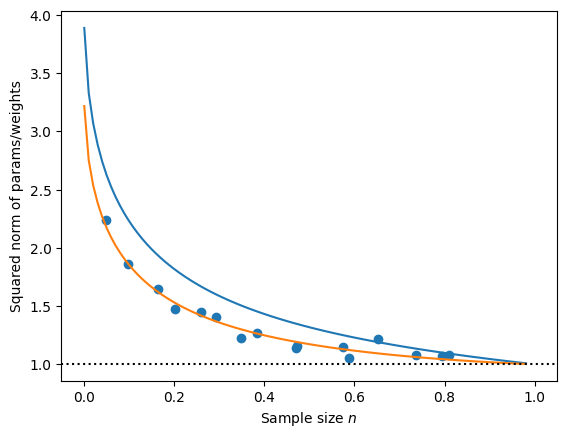

In [11]:
plt.scatter(df['E_tr'], df['E_te'])
from binary_search import binary_search
gamma = 0.75
alpha = 1.75
colors = ['#1f77b4', '#419ede']
def plot_trade_off_curve(gamma, alpha, **kwargs):
    E_te, E_tr, R = get_risk_predictors(gamma, alpha)
    k_crit = binary_search(R,0,n_steps=30, init=1.5, LB=1.0, UB= 2.0)
    ks = np.logspace(np.log10(k_crit), 4, num=100)
    E_tr_inv = get_E_tr_inv(gamma,alpha)
    ks = np.array([E_tr_inv(tau) for tau in np.linspace(0.001,0.98,100)])
    # plt.scatter(df["rreg_E_tr"], df["rreg_E_te"],color = '#1f77b4',label='near-interpol-RR')
    
    
    plt.plot(E_tr(ks),E_te(ks),**kwargs)
    # ks = np.array([E_tr_inv(tau) for tau in np.linspace(0.001,0.98,20)])
    # plt.scatter(E_tr(ks),E_te(ks))
plot_trade_off_curve(gamma=2/3,alpha=2.5, label=r'$\alpha = 1.75$')
plot_trade_off_curve(gamma=2/3,alpha=1.25, label=r'$\alpha = 1.75$')

plt.axhline(y=1, color='k', linestyle=":", label='noise floor')
plt.xlim((-0.05,1.05))


plt.xlabel(r'Sample size $n$')
plt.ylabel(r'Squared norm of params/weights')

